### Imports

In [1]:
## Libraries
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch

from PIL import Image  # Load img
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Python Files
import utils
import datas

### Convert .mat to .png images for memory managment during training

In [2]:
# path2dataset = "nyu_depth_v2_labeled.mat"
# utils.mat2png(path2dataset)

### Load datas

In [3]:
root_folder = 'Datas'

transform = transforms.Compose([            
    transforms.ToTensor()])

train_loader, dataset_train, test_loader, dataset_test = datas.get_loader(root_folder, batch_size=32, num_datas=1449, train_test_ratio=0.9, transform=transform)

torch.Size([32, 3, 480, 640]) torch.Size([32, 3, 480, 640]) torch.Size([32, 3, 480, 640])


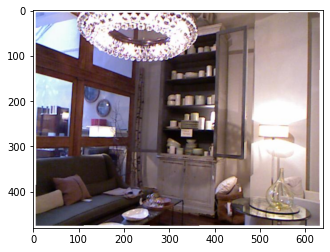

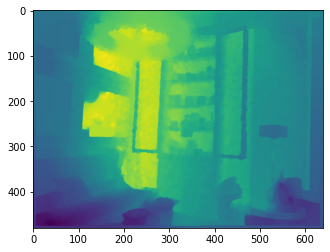

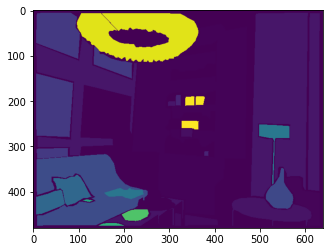

In [10]:
for indx, (images, depths, labels) in enumerate(train_loader):
    print(images.shape, depths.shape, labels.shape)
    plt.imshow(images[0].permute(1,2,0))
    plt.figure()
    plt.imshow(depths[0].permute(1,2,0))
    plt.figure()
    plt.imshow(labels[0].permute(1,2,0))
    break